# Experiment Notebook: How do different settings of the FEI Savings Rate process affect User FEI Capital Allocation?

# Table of Contents
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: ...](#Analysis-1:-...)

# Experiment Summary 

The purpose of this notebook is to assess the impact that various settings of the FEI Savings Rate process have on User FEI Capital Allocation across Liquidity Pool, Money Market, and FEI Savings Deposits.

# Experiment Assumptions

See [assumptions document](../../ASSUMPTIONS.md) for further details.

# Experiment Setup

We begin with several experiment-notebook-level preparatory setup operations:

* Import relevant dependencies
* Import relevant experiment templates
* Create copies of experiments
* Configure and customize experiments 

Analysis-specific setup operations are handled in their respective notebook sections.

In [1]:
# Import the setup module:
# * sets up the Python path
# * runs shared notebook configuration methods, such as loading IPython modules
import setup

import copy
import logging
import numpy as np
import pandas as pd
import plotly.express as px

import experiments.notebooks.visualizations as visualizations
from experiments.run import run
from experiments.utils import display_code

time: 504 ms (started: 2022-08-02 09:24:20 +02:00)


In [2]:
from operator import lt, gt

time: 13.1 ms (started: 2022-08-02 09:24:20 +02:00)


In [3]:
from scipy.stats import norm

time: 13.2 ms (started: 2022-08-02 09:24:20 +02:00)


In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

time: 12.9 ms (started: 2022-08-02 09:24:20 +02:00)


In [5]:
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 1200
png_renderer.height = 500
# png_renderer.scale = 1

pio.renderers.default = "png"

time: 73.4 ms (started: 2022-08-02 09:24:20 +02:00)


In [6]:
# Enable/disable logging
logger = logging.getLogger()
logger.disabled = False

time: 14.6 ms (started: 2022-08-02 09:24:20 +02:00)


In [7]:
# Import experiment templates
import experiments.default_experiment as default_experiment

time: 14.3 ms (started: 2022-08-02 09:24:20 +02:00)


In [8]:
# Create a simulation for each analysis
simulation_1 = copy.deepcopy(default_experiment.experiment.simulations[0])

time: 13.9 ms (started: 2022-08-02 09:24:20 +02:00)


In [9]:
def gen_norm_rv(n, mu, sigma):
    return norm.rvs(loc=mu, scale=sigma, size=1, random_state=n)[0]

time: 24.6 ms (started: 2022-08-02 09:24:20 +02:00)


In [10]:
cam_deposits = [
    "fei_liquidity_pool_user_deposit",
    "fei_money_market_user_deposit",
    "fei_savings_user_deposit",
    "fei_idle_user_deposit",
]

time: 14.5 ms (started: 2022-08-02 09:24:20 +02:00)


In [11]:
parameter_overrides = {
#     "target_rebalancing_condition": [gt, lt], # Simulate decrease and increase of stable PCV
#     "target_stable_pcv_ratio": [0.2, 0.5], # Simulate decrease and increase of stable PCV
#     "rebalancing_period": [int(365 / 4)],
#     "yield_withdrawal_period": [999],  # Disable yield-withdrawal policy
#     "yield_reinvest_period": [999],  # Disable yield-reinvestment policy
    "capital_allocation_fei_deposit_variables": [
            cam_deposits,
    ],
    "capital_allocation_rebalance_duration": [30],
    "fei_savings_rate_process": [
         lambda _run, timestep: 0.01,
         lambda _run, timestep: 0.03,
         lambda _run, timestep: 0.01 if timestep < 365 / 4 else (0.03 if timestep < 365 * 3/4 else 0.01),
    ],
    #"money_market_utilization_rate_process": [
    #    lambda _run, timestep: 0.7, #+ gen_norm_rv(timestep, 0, 0.01),
    #]
}


time: 15.1 ms (started: 2022-08-02 09:24:20 +02:00)


In [12]:
# Experiment configuration

# Override default experiment number of Monte Carlo Runs
simulation_1.runs = 5

# Override default experiment System Initial State
simulation_1.model.initial_state.update({})

# Override default experiment System Parameters
simulation_1.model.params.update(parameter_overrides)

time: 14.9 ms (started: 2022-08-02 09:24:20 +02:00)


## KPI computation (temp)

In [13]:
def compute_vol(x):
    return x.pct_change().std()

time: 19.4 ms (started: 2022-08-02 09:24:21 +02:00)


In [14]:
def compute_max(x):
    return x.max()

time: 15.8 ms (started: 2022-08-02 09:24:21 +02:00)


In [15]:
def compute_min(x):
    return x.min()

time: 13.1 ms (started: 2022-08-02 09:24:21 +02:00)


In [16]:
def compute_final_val(x):
    return x.iloc[-1]

time: 14 ms (started: 2022-08-02 09:24:21 +02:00)


In [17]:
def compute_mdd(x):
    window = 30

    rolling_max = x.rolling(window).max()
    dd = x/rolling_max - 1.0
    
    mdd = dd.rolling(window).min()
    return mdd.min()

time: 19.2 ms (started: 2022-08-02 09:24:21 +02:00)


In [18]:
fn_list = [compute_vol, compute_max, compute_min, compute_final_val, compute_mdd]
fn_names = ['volatility', 'max', 'min', 'final value', 'max dd']
fn_dict = dict(zip(fn_names, fn_list))

time: 13.6 ms (started: 2022-08-02 09:24:21 +02:00)


In [19]:
def generate_emp_distribution_kpi(fn, df, variable, start=None, end=None):
    L = dict()
    for i in list(df['subset'].value_counts().index):
        V = dict()
        for j in list(df['run'].value_counts().index):
            x = df.query('run==@j and subset==@i')[variable].iloc[start:end]
            v = fn(x)
            V[j] = v
            
        L[i] = V
        
    return pd.DataFrame(L)

time: 14.5 ms (started: 2022-08-02 09:24:21 +02:00)


In [20]:
def compute_metric_set_for_variable(df, fn_dict, variable, start=None, end=None):
    L = dict()
    for fn_name, fn in fn_dict.items():
        metric_avg = generate_emp_distribution_kpi(fn, df, variable, start=start, end=end).mean(axis=0)
        L[fn_name] = metric_avg
        
    return pd.DataFrame(L)

time: 14.9 ms (started: 2022-08-02 09:24:21 +02:00)


# Analysis 1: Effect of FEI Savings Rate on User FEI Capital Allocation

In this analysis we look at the effect of setting the FEI savings rate in three ways:
- As a constant process below the money market supply rate
- As a constant process above the money market supply rate
- As a step function which moves between the two processes

We assume the demand for populating each deposit will depend on the rate of yield offered by the deposit, and gauge to what extent the difference in deposit yield affects how deposits are populated. We also look at the effect this has on Liquidity Pools, and a few other downstream effects on mechanism-specific metrics.

In [21]:
# Analysis-specific setup

time: 12.5 ms (started: 2022-08-02 09:24:21 +02:00)


In [22]:
# Experiment execution
df, exceptions = run(simulation_1)

2022-08-02 09:24:21,200 - root - INFO - Running experiment
2022-08-02 09:24:21,202 - root - INFO - Setting up initial state
2022-08-02 09:24:21,205 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-08-02 09:24:21,209 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': -20688423.6619959, 'fei_money_market_user_deposit': 17037882.523241803, 'fei_savings_user_deposit': 3650541.1387540884, 'fei_idle_user_deposit': 0.0} FEI unallocated
2022-08-02 09:24:21,213 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': -5675198.216902263, 'fei_money_market_user_deposit': 2299846.636831641, 'fei_savings_user_deposit': 3375351.580070615, 'fei_idle_user_deposit': 0.0} FEI unallocated
2022-08-02 09:24:21,217 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': -398316.0384329241, 'fei_money_market_user_deposit': -1.4901161193847656e-08,

2022-08-02 09:24:21,558 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 511843.41892296076, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -511843.4189229617} FEI unallocated
2022-08-02 09:24:21,562 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1207693.178964965, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1207693.1789649602} FEI unallocated
2022-08-02 09:24:21,566 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 94442.54743679613, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -94442.54743679217} FEI unallocated
2022-08-02 09:24:21,586 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 274443.72250590473, 'fei_mone

2022-08-02 09:24:21,851 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 249633.28962270916, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -249633.28962270706} FEI unallocated
2022-08-02 09:24:21,855 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 886561.0862705857, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -886561.0862705875} FEI unallocated
2022-08-02 09:24:21,875 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 328238.16820267215, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -328238.168202671} FEI unallocated
2022-08-02 09:24:21,879 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1111373.630041916, 'fei_money

2022-08-02 09:24:22,122 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1049948.7395420857, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1049948.7395420824} FEI unallocated
2022-08-02 09:24:22,131 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 144256.84320578724, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -144256.84320578887} FEI unallocated
2022-08-02 09:24:22,151 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 426901.5092985891, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -426901.5092985893} FEI unallocated
2022-08-02 09:24:22,156 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 966638.1503184102, 'fei_mon

2022-08-02 09:24:22,419 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1172238.0554175973, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1172238.0554175957} FEI unallocated
2022-08-02 09:24:22,423 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 185069.63309715316, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -185069.6330971548} FEI unallocated
2022-08-02 09:24:22,438 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 326571.3568879999, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -326571.35688799736} FEI unallocated
2022-08-02 09:24:22,441 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1073818.9459577054, 'fei_mo

2022-08-02 09:24:22,697 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 162275.3675815761, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -162275.3675815768} FEI unallocated
2022-08-02 09:24:22,716 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1022540.5021491162, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1022540.5021491137} FEI unallocated
2022-08-02 09:24:22,734 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 534705.7320389189, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -534705.7320389193} FEI unallocated
2022-08-02 09:24:22,738 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 809201.7312314585, 'fei_money

2022-08-02 09:24:23,008 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2195980.6082391404, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -2195980.6082391404} FEI unallocated
2022-08-02 09:24:23,012 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 140872.2271747701, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -140872.2271747659} FEI unallocated
2022-08-02 09:24:23,028 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 507625.13328331336, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -507625.13328331104} FEI unallocated
2022-08-02 09:24:23,033 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2067406.9640027136, 'fei_mo

2022-08-02 09:24:23,283 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 174530.48851823434, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -174530.48851823178} FEI unallocated
2022-08-02 09:24:23,302 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1540055.0225601308, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1540055.0225601266} FEI unallocated
2022-08-02 09:24:23,306 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 77360.52950769663, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -77360.52950769477} FEI unallocated
2022-08-02 09:24:23,324 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1458668.850953687, 'fei_mon

2022-08-02 09:24:23,594 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1456728.1488467343, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1456728.148846732} FEI unallocated
2022-08-02 09:24:23,599 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 84900.10849329084, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -84900.10849328618} FEI unallocated
2022-08-02 09:24:23,617 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1559088.6040046625, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1559088.604004662} FEI unallocated
2022-08-02 09:24:23,621 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 131020.06572551653, 'fei_mone

2022-08-02 09:24:23,917 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 182702.8983281888, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -182702.89832818555} FEI unallocated
2022-08-02 09:24:23,934 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1140213.5310463905, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1140213.531046391} FEI unallocated
2022-08-02 09:24:23,941 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 211542.15944577008, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -211542.15944576752} FEI unallocated
2022-08-02 09:24:23,961 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 209213.5832995884, 'fei_mon

2022-08-02 09:24:24,242 - root - INFO - Starting simulation 0 / run 0 / subset 2
2022-08-02 09:24:24,245 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': -20688423.6619959, 'fei_money_market_user_deposit': 17037882.523241803, 'fei_savings_user_deposit': 3650541.1387540884, 'fei_idle_user_deposit': 0.0} FEI unallocated
2022-08-02 09:24:24,249 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': -5675198.216902263, 'fei_money_market_user_deposit': 2299846.636831641, 'fei_savings_user_deposit': 3375351.580070615, 'fei_idle_user_deposit': 0.0} FEI unallocated
2022-08-02 09:24:24,255 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': -398316.0384329241, 'fei_money_market_user_deposit': -1.4901161193847656e-08, 'fei_savings_user_deposit': 398316.03843292594, 'fei_idle_user_deposit': -1.4901161193847656e-08} FEI unallocated
2022-08-0

2022-08-02 09:24:24,541 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1207693.178964965, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1207693.1789649602} FEI unallocated
2022-08-02 09:24:24,545 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 94442.54743679613, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -94442.54743679217} FEI unallocated
2022-08-02 09:24:24,560 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 274443.72250590473, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -274443.7225059051} FEI unallocated
2022-08-02 09:24:24,565 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1263099.6719427444, 'fei_mone

2022-08-02 09:24:24,840 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 94772.90043814108, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -94772.90043814224} FEI unallocated
2022-08-02 09:24:24,867 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1557908.9487813227, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1557908.9487813183} FEI unallocated
2022-08-02 09:24:24,872 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 170761.7484088391, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -170761.7484088405} FEI unallocated
2022-08-02 09:24:24,891 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1023400.6760570183, 'fei_mone

2022-08-02 09:24:25,138 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1489001.6336853541, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1489001.6336853518} FEI unallocated
2022-08-02 09:24:25,142 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 260520.99342432246, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -260520.9934243178} FEI unallocated
2022-08-02 09:24:25,160 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1561750.9641079493, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1561750.9641079472} FEI unallocated
2022-08-02 09:24:25,164 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 256644.16101372242, 'fei_m

2022-08-02 09:24:25,410 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 736959.986636065, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -736959.986636066} FEI unallocated
2022-08-02 09:24:25,414 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1058639.8376066722, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1058639.8376066731} FEI unallocated
2022-08-02 09:24:25,418 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 255464.45356539637, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -255464.45356539357} FEI unallocated
2022-08-02 09:24:25,433 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 24404.477645341307, 'fei_mone

2022-08-02 09:24:25,680 - root - INFO - Starting simulation 0 / run 1 / subset 0
2022-08-02 09:24:25,683 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': -19333809.28904184, 'fei_money_market_user_deposit': 18279439.805241436, 'fei_savings_user_deposit': 1054369.4838003963, 'fei_idle_user_deposit': 0.0} FEI unallocated
2022-08-02 09:24:25,687 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': -3367632.010192886, 'fei_money_market_user_deposit': 2302135.1669661626, 'fei_savings_user_deposit': 1065496.843226716, 'fei_idle_user_deposit': 0.0} FEI unallocated
2022-08-02 09:24:25,759 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2768595.083676748, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -2768595.08367675} FEI unallocated
2022-08-02 09:24:25,763 - root - WARNING - Capita

2022-08-02 09:24:25,978 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 89533.43220895156, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -89533.43220895226} FEI unallocated
2022-08-02 09:24:25,993 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 647349.4987529926, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -647349.4987529935} FEI unallocated
2022-08-02 09:24:25,997 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1315586.3653299622, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1315586.3653299604} FEI unallocated
2022-08-02 09:24:26,002 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 103290.59034260362, 'fei_mone

2022-08-02 09:24:26,236 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 197619.37901015952, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -197619.37901015882} FEI unallocated
2022-08-02 09:24:26,251 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 315049.77598598227, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -315049.77598598157} FEI unallocated
2022-08-02 09:24:26,255 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1007996.4629111663, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1007996.462911163} FEI unallocated
2022-08-02 09:24:26,260 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 124407.94614912942, 'fei_m

2022-08-02 09:24:26,491 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 931882.1065327078, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -931882.1065327108} FEI unallocated
2022-08-02 09:24:26,495 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 43276.97896539047, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -43276.978965388145} FEI unallocated
2022-08-02 09:24:26,510 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 271544.2174490094, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -271544.2174490059} FEI unallocated
2022-08-02 09:24:26,514 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 916955.9128609337, 'fei_money_

2022-08-02 09:24:26,767 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 511796.1208304614, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -511796.1208304665} FEI unallocated
2022-08-02 09:24:26,772 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1060101.8703132942, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1060101.870313292} FEI unallocated
2022-08-02 09:24:26,776 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 132847.7257078737, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -132847.7257078765} FEI unallocated
2022-08-02 09:24:26,792 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 547734.0475975797, 'fei_money_

2022-08-02 09:24:27,019 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 118257.22800574452, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -118257.22800574335} FEI unallocated
2022-08-02 09:24:27,038 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 55804.881385974586, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -55804.88138597377} FEI unallocated
2022-08-02 09:24:27,044 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 980718.9952430762, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -980718.9952430718} FEI unallocated
2022-08-02 09:24:27,049 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 181540.58303515613, 'fei_mon

2022-08-02 09:24:27,310 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2757684.3337541968, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -2757684.3337542} FEI unallocated
2022-08-02 09:24:27,316 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 274574.41873139516, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -274574.4187313933} FEI unallocated
2022-08-02 09:24:27,331 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 200905.35099342465, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -200905.3509934235} FEI unallocated
2022-08-02 09:24:27,335 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2080678.3699016757, 'fei_money

2022-08-02 09:24:27,597 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 169175.06343706325, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -169175.0634370651} FEI unallocated
2022-08-02 09:24:27,615 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1545186.5346285775, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1545186.5346285773} FEI unallocated
2022-08-02 09:24:27,619 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 206431.6190520525, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -206431.61905205646} FEI unallocated
2022-08-02 09:24:27,639 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1710425.0225054473, 'fei_mo

2022-08-02 09:24:27,898 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 218368.41837836802, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -218368.41837836686} FEI unallocated
2022-08-02 09:24:27,913 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 65019.10430075601, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -65019.10430075717} FEI unallocated
2022-08-02 09:24:27,917 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1553207.3564042263, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1553207.3564042267} FEI unallocated
2022-08-02 09:24:27,921 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 182657.55168427154, 'fei_mo

2022-08-02 09:24:28,191 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 44030.2918628864, 'fei_money_market_user_deposit': 157115.47826019116, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -201145.77012307546} FEI unallocated
2022-08-02 09:24:28,208 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 157173.1266337633, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -157173.12663376424} FEI unallocated
2022-08-02 09:24:28,212 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1915404.6650172845, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1915404.6650172789} FEI unallocated
2022-08-02 09:24:28,217 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 241402.875783

2022-08-02 09:24:28,540 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 249131.50503864884, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -249131.50503864512} FEI unallocated
2022-08-02 09:24:28,558 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1856157.0096623786, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1856157.0096623758} FEI unallocated
2022-08-02 09:24:28,563 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 205152.81775644422, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -205152.81775644282} FEI unallocated
2022-08-02 09:24:28,577 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 138010.65864247456, 'fei_

2022-08-02 09:24:28,850 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 126961.49110781401, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -126961.49110781169} FEI unallocated
2022-08-02 09:24:28,865 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 583424.1852443516, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -583424.1852443584} FEI unallocated
2022-08-02 09:24:28,869 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1155704.1008231565, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1155704.1008231519} FEI unallocated
2022-08-02 09:24:28,873 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 70528.39093433693, 'fei_mon

2022-08-02 09:24:29,211 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1761222.3801698312, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1761222.380169831} FEI unallocated
2022-08-02 09:24:29,215 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 235806.98135754466, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -235806.98135754233} FEI unallocated
2022-08-02 09:24:29,237 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 33558.3345698975, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -33558.3345698975} FEI unallocated
2022-08-02 09:24:29,241 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1592258.1159535274, 'fei_money

2022-08-02 09:24:29,481 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 125193.86935084686, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -125193.86935084802} FEI unallocated
2022-08-02 09:24:29,498 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1469589.0513924435, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1469589.051392444} FEI unallocated
2022-08-02 09:24:29,502 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 102376.27592457831, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -102376.27592457645} FEI unallocated
2022-08-02 09:24:29,517 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 32474.994397826493, 'fei_m

2022-08-02 09:24:29,768 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 199451.7822042182, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -199451.78220421728} FEI unallocated
2022-08-02 09:24:29,783 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 761921.3065230846, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -761921.3065230784} FEI unallocated
2022-08-02 09:24:29,787 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1211923.6054399796, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1211923.6054399773} FEI unallocated
2022-08-02 09:24:29,791 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 186459.12469883636, 'fei_mon

2022-08-02 09:24:30,023 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 982908.0399332345, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -982908.0399332388} FEI unallocated
2022-08-02 09:24:30,029 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 182172.03019933403, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -182172.03019933333} FEI unallocated
2022-08-02 09:24:30,044 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 640402.1688332781, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -640402.168833284} FEI unallocated
2022-08-02 09:24:30,048 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1087427.425245881, 'fei_money_

2022-08-02 09:24:30,314 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 262803.50695051625, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -262803.5069505172} FEI unallocated
2022-08-02 09:24:30,334 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1287371.77359334, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1287371.7735933377} FEI unallocated
2022-08-02 09:24:30,338 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 96212.54695548862, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -96212.54695548536} FEI unallocated
2022-08-02 09:24:30,353 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 553635.7475444712, 'fei_money_

2022-08-02 09:24:30,580 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 162899.0842414163, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -162899.0842414205} FEI unallocated
2022-08-02 09:24:30,600 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 958067.9710154571, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -958067.971015454} FEI unallocated
2022-08-02 09:24:30,621 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 613830.6883821711, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -613830.6883821734} FEI unallocated
2022-08-02 09:24:30,625 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1034408.0668696351, 'fei_money_m

2022-08-02 09:24:30,907 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 252743.1130880192, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -252743.11308801582} FEI unallocated
2022-08-02 09:24:30,912 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 914059.4672168009, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -914059.4672167995} FEI unallocated
2022-08-02 09:24:30,932 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 688621.515437495, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -688621.5154374926} FEI unallocated
2022-08-02 09:24:30,936 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 45395.970008030534, 'fei_money_

2022-08-02 09:24:31,186 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 856504.2319147103, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -856504.2319147139} FEI unallocated
2022-08-02 09:24:31,190 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 120135.6188349612, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -120135.61883495678} FEI unallocated
2022-08-02 09:24:31,207 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 73447.9949212186, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -73447.9949212179} FEI unallocated
2022-08-02 09:24:31,211 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 795680.532605134, 'fei_money_mar

2022-08-02 09:24:31,452 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 107052.34448621795, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -107052.34448621841} FEI unallocated
2022-08-02 09:24:31,467 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 81046.76998637989, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -81046.7699863796} FEI unallocated
2022-08-02 09:24:31,471 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 842930.1116532311, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -842930.1116532312} FEI unallocated
2022-08-02 09:24:31,475 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 167883.92604091018, 'fei_money

2022-08-02 09:24:31,760 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 58197.62602345273, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -58197.626023454126} FEI unallocated
2022-08-02 09:24:31,765 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2479036.2408168353, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -2479036.2408168325} FEI unallocated
2022-08-02 09:24:31,770 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 408977.76054517925, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -408977.7605451797} FEI unallocated
2022-08-02 09:24:31,791 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2299474.716137372, 'fei_mon

2022-08-02 09:24:32,050 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 192456.49229855463, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -192456.49229855277} FEI unallocated
2022-08-02 09:24:32,069 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1488956.253792137, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1488956.2537921336} FEI unallocated
2022-08-02 09:24:32,073 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 171723.86825368926, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -171723.8682536888} FEI unallocated
2022-08-02 09:24:32,091 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1587255.4726118334, 'fei_mo

2022-08-02 09:24:32,370 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1014010.4960164502, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1014010.4960164506} FEI unallocated
2022-08-02 09:24:32,377 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 214921.1794310771, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -214921.17943107663} FEI unallocated
2022-08-02 09:24:32,401 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1141845.372520607, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1141845.3725206084} FEI unallocated
2022-08-02 09:24:32,405 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 267615.97148176655, 'fei_mo

2022-08-02 09:24:32,695 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1119181.290893197, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1119181.2908931966} FEI unallocated
2022-08-02 09:24:32,700 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 113770.4679727368, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -113770.467972741} FEI unallocated
2022-08-02 09:24:32,719 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1019971.172829397, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1019971.1728293976} FEI unallocated
2022-08-02 09:24:32,723 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 88600.34268644825, 'fei_money_

2022-08-02 09:24:32,982 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 224801.66367921233, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -224801.6636792072} FEI unallocated
2022-08-02 09:24:33,001 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 980923.7584905922, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -980923.7584905918} FEI unallocated
2022-08-02 09:24:33,005 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 181262.0470464304, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -181262.047046429} FEI unallocated
2022-08-02 09:24:33,023 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1259570.1165981367, 'fei_money_

2022-08-02 09:24:33,306 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 207076.04258039594, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -207076.0425803985} FEI unallocated
2022-08-02 09:24:33,327 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 184416.33737386763, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -184416.3373738695} FEI unallocated
2022-08-02 09:24:33,331 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1093644.6807670146, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1093644.6807670165} FEI unallocated
2022-08-02 09:24:33,335 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 104269.38513483852, 'fei_mo

2022-08-02 09:24:33,597 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1313918.3482045531, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1313918.3482045522} FEI unallocated
2022-08-02 09:24:33,601 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 136223.1870626621, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -136223.18706265814} FEI unallocated
2022-08-02 09:24:33,620 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1228991.4677010216, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1228991.4677010216} FEI unallocated
2022-08-02 09:24:33,624 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 105188.77991401404, 'fei_m

2022-08-02 09:24:33,889 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 775021.1879780814, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -775021.1879780798} FEI unallocated
2022-08-02 09:24:33,909 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 562814.3924797662, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -562814.3924797628} FEI unallocated
2022-08-02 09:24:33,913 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1006252.535698507, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1006252.5356985059} FEI unallocated
2022-08-02 09:24:33,917 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 29584.53817883879, 'fei_money_

2022-08-02 09:24:34,167 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 933246.1584061049, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -933246.1584061037} FEI unallocated
2022-08-02 09:24:34,172 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 107069.85613992438, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -107069.85613992438} FEI unallocated
2022-08-02 09:24:34,187 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 249343.36931711063, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -249343.3693171098} FEI unallocated
2022-08-02 09:24:34,191 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 949289.4091401249, 'fei_mone

2022-08-02 09:24:34,437 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 156263.23250468448, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -156263.23250468448} FEI unallocated
2022-08-02 09:24:34,455 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 753341.3409923539, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -753341.3409923544} FEI unallocated
2022-08-02 09:24:34,462 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 104640.14420245588, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -104640.14420245402} FEI unallocated
2022-08-02 09:24:34,484 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 375212.7413738668, 'fei_mon

2022-08-02 09:24:34,750 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 317540.86661941186, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -317540.8666194086} FEI unallocated
2022-08-02 09:24:34,764 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 588845.1134893708, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -588845.1134893657} FEI unallocated
2022-08-02 09:24:34,768 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1221909.050166376, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1221909.050166375} FEI unallocated
2022-08-02 09:24:34,773 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 198801.79323638603, 'fei_money

2022-08-02 09:24:35,021 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 194981.0332403034, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -194981.03324030072} FEI unallocated
2022-08-02 09:24:35,025 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1243268.923934292, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1243268.92393429} FEI unallocated
2022-08-02 09:24:35,028 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 273009.7889038734, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -273009.7889038734} FEI unallocated
2022-08-02 09:24:35,045 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 81625.54324607179, 'fei_money_m

2022-08-02 09:24:35,252 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1276147.9660959542, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1276147.9660959512} FEI unallocated
2022-08-02 09:24:35,257 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 107861.21255840361, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -107861.21255840524} FEI unallocated
2022-08-02 09:24:35,272 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 268512.20420098305, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -268512.2042009843} FEI unallocated
2022-08-02 09:24:35,276 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1180926.3039998226, 'fei_m

2022-08-02 09:24:35,540 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 419267.7420254089, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -419267.7420254089} FEI unallocated
2022-08-02 09:24:35,544 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1045949.4483153969, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1045949.4483153976} FEI unallocated
2022-08-02 09:24:35,548 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 58456.23461556062, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -58456.23461555783} FEI unallocated
2022-08-02 09:24:35,565 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 296640.65901564807, 'fei_mone

2022-08-02 09:24:35,802 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 533622.3831972294, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -533622.3831972303} FEI unallocated
2022-08-02 09:24:35,806 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1221104.0895825215, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1221104.0895825184} FEI unallocated
2022-08-02 09:24:35,810 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 130593.57039849833, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -130593.5703984946} FEI unallocated
2022-08-02 09:24:35,824 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 395492.0142480023, 'fei_mone

2022-08-02 09:24:36,113 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 575055.1894501597, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -575055.1894501531} FEI unallocated
2022-08-02 09:24:36,128 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 571554.6770855002, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -571554.6770854951} FEI unallocated
2022-08-02 09:24:36,133 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 3030784.8101181053, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -3030784.8101181043} FEI unallocated
2022-08-02 09:24:36,137 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 529621.1050224155, 'fei_money

2022-08-02 09:24:36,392 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 246016.19911593944, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -246016.19911593408} FEI unallocated
2022-08-02 09:24:36,396 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1983097.1594785526, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1983097.1594785554} FEI unallocated
2022-08-02 09:24:36,400 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 254195.3393730782, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -254195.33937307773} FEI unallocated
2022-08-02 09:24:36,418 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1536433.5380803272, 'fei_m

2022-08-02 09:24:36,665 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 209554.27807759866, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -209554.27807759773} FEI unallocated
2022-08-02 09:24:36,680 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 278750.0194922723, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -278750.01949227205} FEI unallocated
2022-08-02 09:24:36,686 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1671276.5155463777, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1671276.5155463705} FEI unallocated
2022-08-02 09:24:36,690 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 165675.95265116543, 'fei_m

2022-08-02 09:24:36,975 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 124516.90100844577, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -124516.901008446} FEI unallocated
2022-08-02 09:24:36,991 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 100748.17589647695, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -100748.17589647358} FEI unallocated
2022-08-02 09:24:36,996 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1731903.2033245936, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1731903.2033245931} FEI unallocated
2022-08-02 09:24:37,000 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 226174.72381240875, 'fei_mo

2022-08-02 09:24:37,265 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 203945.8572501056, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -203945.85725010117} FEI unallocated
2022-08-02 09:24:37,281 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 113169.12458086386, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -113169.1245808634} FEI unallocated
2022-08-02 09:24:37,286 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1806664.7514948323, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1806664.7514948286} FEI unallocated
2022-08-02 09:24:37,291 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 254441.24627411366, 'fei_mo

2022-08-02 09:24:37,591 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2232208.3368077725, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -2232208.3368077697} FEI unallocated
2022-08-02 09:24:37,595 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 291732.914791815, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -291732.91479180893} FEI unallocated
2022-08-02 09:24:37,609 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1301144.3930915073, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1301144.393091503} FEI unallocated
2022-08-02 09:24:37,613 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2006815.8799448386, 'fei_mon

2022-08-02 09:24:37,831 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 148960.74277212098, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -148960.74277211778} FEI unallocated
2022-08-02 09:24:37,835 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1189540.3065717705, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1189540.3065717698} FEI unallocated
2022-08-02 09:24:37,839 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 87946.44611320272, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -87946.44611320086} FEI unallocated
2022-08-02 09:24:37,858 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1397926.9874236956, 'fei_mo

2022-08-02 09:24:38,156 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 249851.95532764122, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -249851.95532764052} FEI unallocated
2022-08-02 09:24:38,162 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1572204.0213721208, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1572204.0213721178} FEI unallocated
2022-08-02 09:24:38,168 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 128250.8672992289, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -128250.8672992289} FEI unallocated
2022-08-02 09:24:38,186 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1649596.334887866, 'fei_mon

2022-08-02 09:24:38,453 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 135921.66210130602, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -135921.6621013058} FEI unallocated
2022-08-02 09:24:38,475 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1585383.2076365538, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1585383.20763655} FEI unallocated
2022-08-02 09:24:38,480 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 199138.13723385334, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -199138.13723385008} FEI unallocated
2022-08-02 09:24:38,498 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1556064.645300746, 'fei_mone

2022-08-02 09:24:38,754 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 412122.14239196107, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -412122.14239196014} FEI unallocated
2022-08-02 09:24:38,759 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1087579.5869984329, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1087579.5869984336} FEI unallocated
2022-08-02 09:24:38,763 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 90806.14092861488, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -90806.14092861372} FEI unallocated
2022-08-02 09:24:38,782 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1032593.8445358165, 'fei_mo

2022-08-02 09:24:39,070 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 265907.43032851815, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -265907.4303285186} FEI unallocated
2022-08-02 09:24:39,086 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1197337.1170629747, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1197337.1170629747} FEI unallocated
2022-08-02 09:24:39,090 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2331901.4090630487, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -2331901.409063047} FEI unallocated
2022-08-02 09:24:39,095 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 171012.9385302812, 'fei_mon

2022-08-02 09:24:39,349 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 249840.9793781154, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -249840.979378114} FEI unallocated
2022-08-02 09:24:39,354 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 994630.8905441351, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -994630.8905441349} FEI unallocated
2022-08-02 09:24:39,358 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 100051.00533623621, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -100051.00533623714} FEI unallocated
2022-08-02 09:24:39,374 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 372059.3319090605, 'fei_money_

2022-08-02 09:24:39,619 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1020439.5024262518, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1020439.5024262489} FEI unallocated
2022-08-02 09:24:39,624 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 134055.17212873325, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -134055.17212873278} FEI unallocated
2022-08-02 09:24:39,642 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 197908.7422255166, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -197908.74222551496} FEI unallocated
2022-08-02 09:24:39,648 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1039165.4998851754, 'fei_m

2022-08-02 09:24:39,912 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 287633.70272732154, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -287633.702727324} FEI unallocated
2022-08-02 09:24:39,916 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1283343.567269031, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1283343.5672690305} FEI unallocated
2022-08-02 09:24:39,921 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 87311.57767766714, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -87311.577677669} FEI unallocated
2022-08-02 09:24:39,935 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 88488.57005643845, 'fei_money_ma

2022-08-02 09:24:40,154 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1112251.8580377959, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1112251.8580377926} FEI unallocated
2022-08-02 09:24:40,158 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 225738.41203462332, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -225738.41203461937} FEI unallocated
2022-08-02 09:24:40,177 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1025786.6084045582, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1025786.6084045571} FEI unallocated
2022-08-02 09:24:40,181 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 124612.51724483073, 'fei_

2022-08-02 09:24:40,429 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1018073.981144581, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1018073.981144584} FEI unallocated
2022-08-02 09:24:40,435 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 133022.99380823597, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -133022.99380823458} FEI unallocated
2022-08-02 09:24:40,454 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 471052.47533713654, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -471052.47533713793} FEI unallocated
2022-08-02 09:24:40,454 - root - INFO - Setting up initial state
2022-08-02 09:24:40,457 - root - INFO - Starting simulation 0 / run 4 / subset 1
2022-08-02

2022-08-02 09:24:40,702 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 206249.48951204866, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -206249.4895120468} FEI unallocated
2022-08-02 09:24:40,717 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 321832.5126719251, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -321832.5126719263} FEI unallocated
2022-08-02 09:24:40,721 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2046930.9391050823, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -2046930.9391050814} FEI unallocated
2022-08-02 09:24:40,725 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 287604.1870029308, 'fei_mone

2022-08-02 09:24:40,994 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 173776.2729486376, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -173776.27294863889} FEI unallocated
2022-08-02 09:24:40,998 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1700833.2820148207, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1700833.2820148175} FEI unallocated
2022-08-02 09:24:41,002 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 213115.87234312668, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -213115.8723431253} FEI unallocated
2022-08-02 09:24:41,019 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1672226.965821918, 'fei_mon

2022-08-02 09:24:41,340 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1665929.5043809265, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1665929.5043809302} FEI unallocated
2022-08-02 09:24:41,344 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 153580.4874787368, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -153580.48747873493} FEI unallocated
2022-08-02 09:24:41,372 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1822918.9664951935, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1822918.9664951926} FEI unallocated
2022-08-02 09:24:41,380 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 159453.25669269636, 'fei_m

2022-08-02 09:24:41,785 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1840923.177828513, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1840923.1778285077} FEI unallocated
2022-08-02 09:24:41,790 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 118840.76941232756, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -118840.76941232942} FEI unallocated
2022-08-02 09:24:41,810 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 201175.2155150026, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -201175.21551500098} FEI unallocated
2022-08-02 09:24:41,816 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1484306.29107349, 'fei_mone

2022-08-02 09:24:42,198 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 5234956.902102724, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -5234956.902102723} FEI unallocated
2022-08-02 09:24:42,203 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 514926.918724142, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -514926.9187241383} FEI unallocated
2022-08-02 09:24:42,225 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 213713.50350434706, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -213713.50350434938} FEI unallocated
2022-08-02 09:24:42,232 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 2148644.8522794545, 'fei_money

2022-08-02 09:24:42,524 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1312425.665647816, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1312425.6656478136} FEI unallocated
2022-08-02 09:24:42,528 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 165088.36779743806, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -165088.36779743666} FEI unallocated
2022-08-02 09:24:42,546 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1343288.5995906182, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1343288.5995906158} FEI unallocated
2022-08-02 09:24:42,554 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 127052.11098405346, 'fei_m

2022-08-02 09:24:42,883 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1509088.5624997653, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1509088.5624997634} FEI unallocated
2022-08-02 09:24:42,888 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 169392.88115394488, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -169392.88115394162} FEI unallocated
2022-08-02 09:24:42,914 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1406069.7159416229, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1406069.7159416252} FEI unallocated
2022-08-02 09:24:42,918 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 123466.74559843168, 'fei_

2022-08-02 09:24:43,219 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 70047.9279792495, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -70047.92797925009} FEI unallocated
2022-08-02 09:24:43,224 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1949747.7425345741, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1949747.742534569} FEI unallocated
2022-08-02 09:24:43,228 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 261220.06285592914, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -261220.0628559296} FEI unallocated
2022-08-02 09:24:43,244 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 303754.2977750562, 'fei_money_

2022-08-02 09:24:43,479 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1120942.772072073, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -1120942.7720720712} FEI unallocated
2022-08-02 09:24:43,483 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 214881.16418556497, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -214881.16418556334} FEI unallocated
2022-08-02 09:24:43,498 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 259958.20552336425, 'fei_money_market_user_deposit': 0.0, 'fei_savings_user_deposit': 0.0, 'fei_idle_user_deposit': -259958.20552336483} FEI unallocated
2022-08-02 09:24:43,503 - root - WARNING - Capital allocation rebalancing error: movement of {'fei_liquidity_pool_user_deposit': 1057087.8478518575, 'fei_m

In [23]:
# Post-processing and visualizations

time: 11.9 ms (started: 2022-08-02 09:24:51 +02:00)


### visualization of parameter sweep:

we sweep the fei savings rate process for three values, two constant processes and a step function

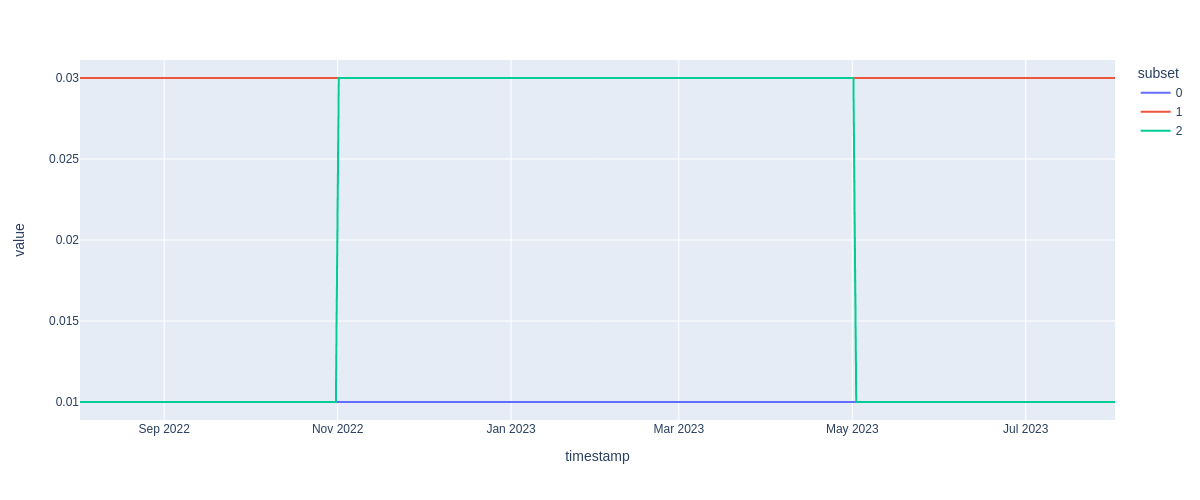

time: 2.08 s (started: 2022-08-02 09:24:51 +02:00)


In [24]:
df.query('run==1').plot(x='timestamp', y=['fei_savings_rate'], color='subset')

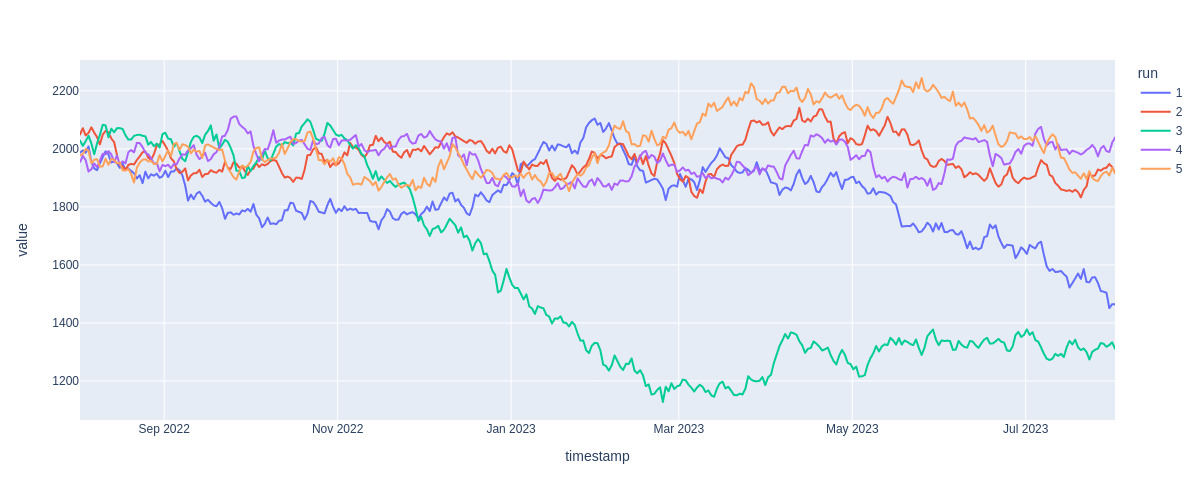

time: 917 ms (started: 2022-08-02 09:24:53 +02:00)


In [25]:
df.query('subset==0').plot(x='timestamp', y=['volatile_asset_price'], color='run')

In [26]:
use_cols = [key + '_balance' for key in cam_deposits]

time: 19.6 ms (started: 2022-08-02 09:24:54 +02:00)


In [27]:
def get_weight_evolution(df, subset):
    df_ = pd.DataFrame(
            df.query('subset==@subset')['capital_allocation_target_weights'].to_list(),
        )
    
    df_.index = df.query('subset==@subset')['timestamp']
    return df_

time: 17.1 ms (started: 2022-08-02 09:24:54 +02:00)


In [28]:
def get_weight_evolution_average(df, subset):
    
    balances = pd.DataFrame(df.query('subset==@subset')["capital_allocation_target_weights"].to_list(),
             columns=use_cols)
    
    df_ = df.query('subset==@subset')[['timestep']].reset_index()
    
    df_ = pd.concat([df_, balances], axis=1).set_index('timestamp')
    
    df_ = df_.groupby('timestep').mean()
    
    df_.index = df.query('subset==@subset and run==1')['timestamp']
    
    return df_

time: 19.8 ms (started: 2022-08-02 09:24:54 +02:00)


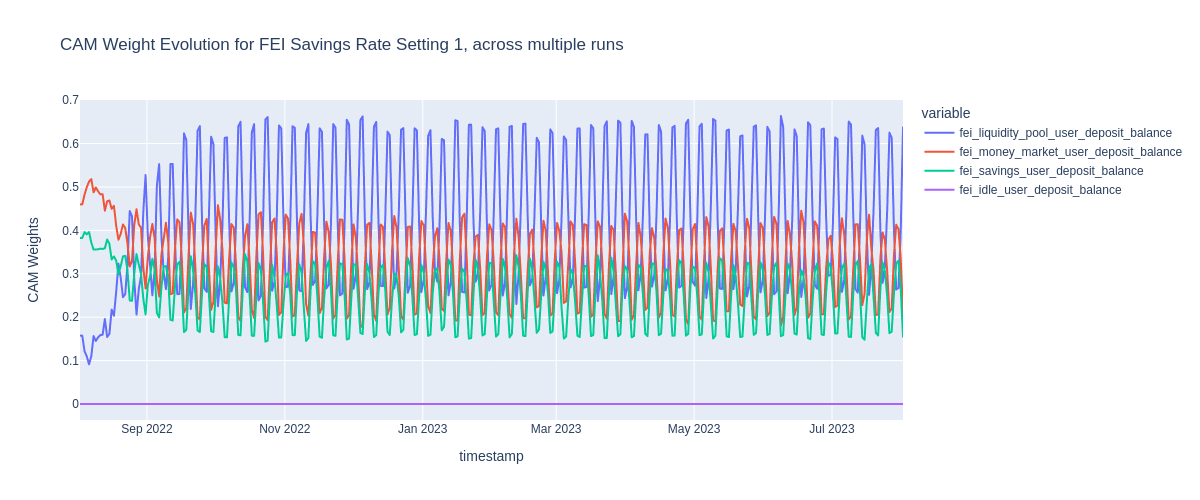

time: 848 ms (started: 2022-08-02 09:24:54 +02:00)


In [29]:
get_weight_evolution_average(df, 0).plot(
    title='CAM Weight Evolution for FEI Savings Rate Setting 1, across multiple runs',
     labels={
         "value": "CAM Weights",
     },
)

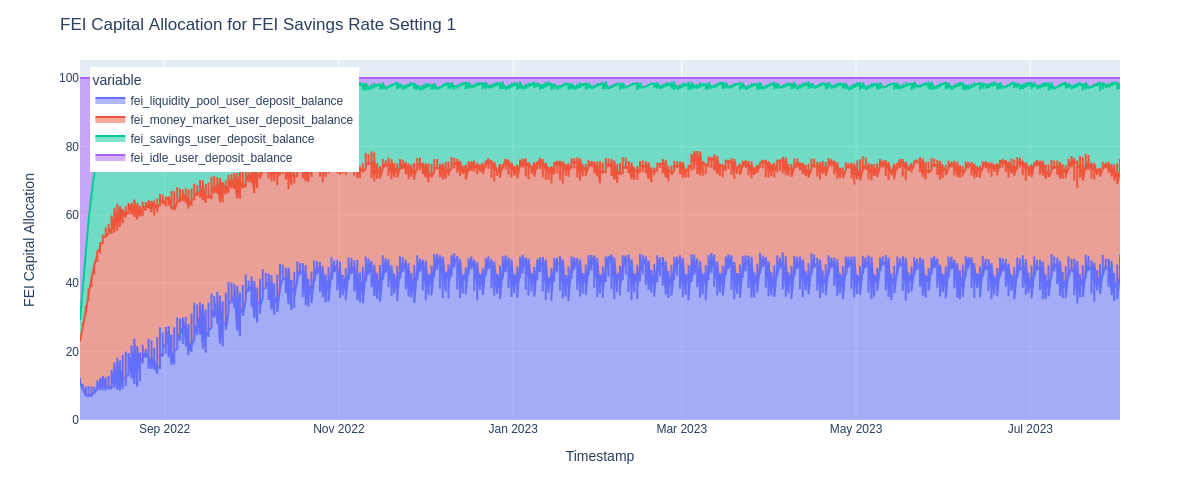

time: 320 ms (started: 2022-08-02 09:24:55 +02:00)


In [30]:
fig = px.area(df.query('subset==0'), x='timestamp', y=use_cols, groupnorm="percent")

fig.update_layout(
    title="FEI Capital Allocation for FEI Savings Rate Setting 1",
    xaxis_title="Timestamp",
    yaxis_title="FEI Capital Allocation",
    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01
    )
)
fig.show()

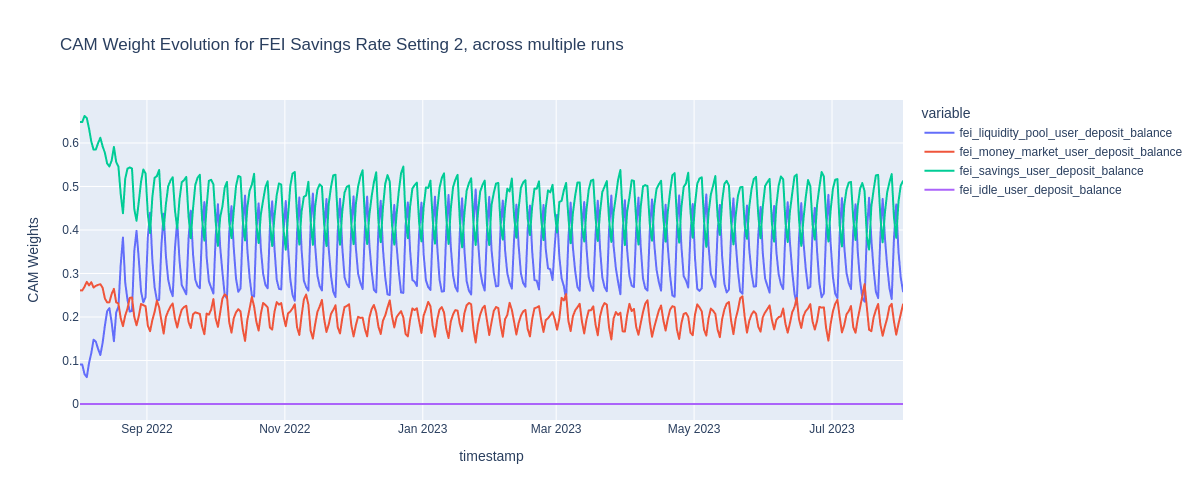

time: 946 ms (started: 2022-08-02 09:24:55 +02:00)


In [31]:
get_weight_evolution_average(df, 1).plot(
    title='CAM Weight Evolution for FEI Savings Rate Setting 2, across multiple runs',
     labels={
         "value": "CAM Weights",
     },
)

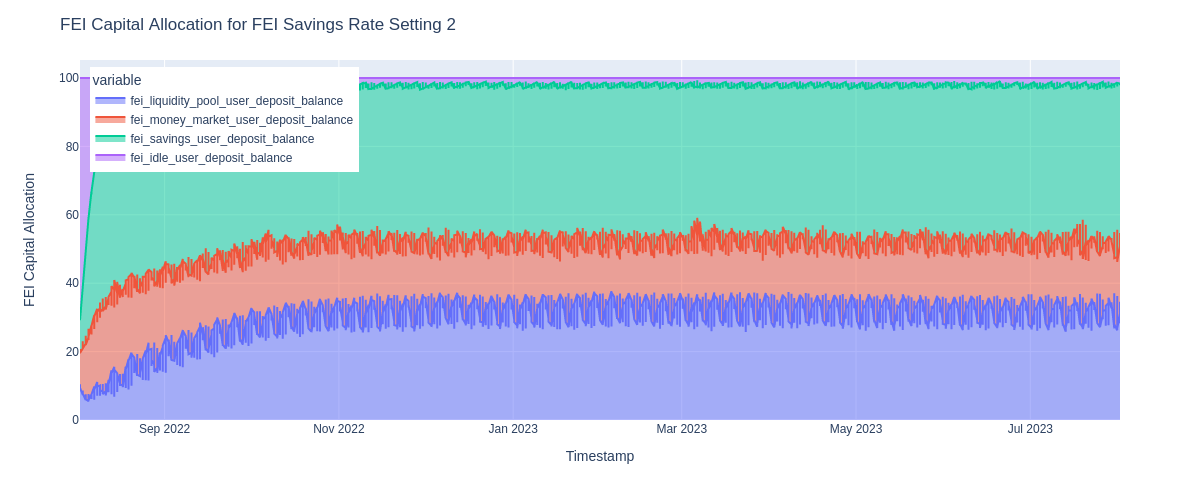

time: 356 ms (started: 2022-08-02 09:24:56 +02:00)


In [32]:
fig = px.area(df.query('subset==1'), x='timestamp', y=use_cols, groupnorm="percent")

fig.update_layout(
    title="FEI Capital Allocation for FEI Savings Rate Setting 2",
    xaxis_title="Timestamp",
    yaxis_title="FEI Capital Allocation",
    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01
    )
)

fig.show()

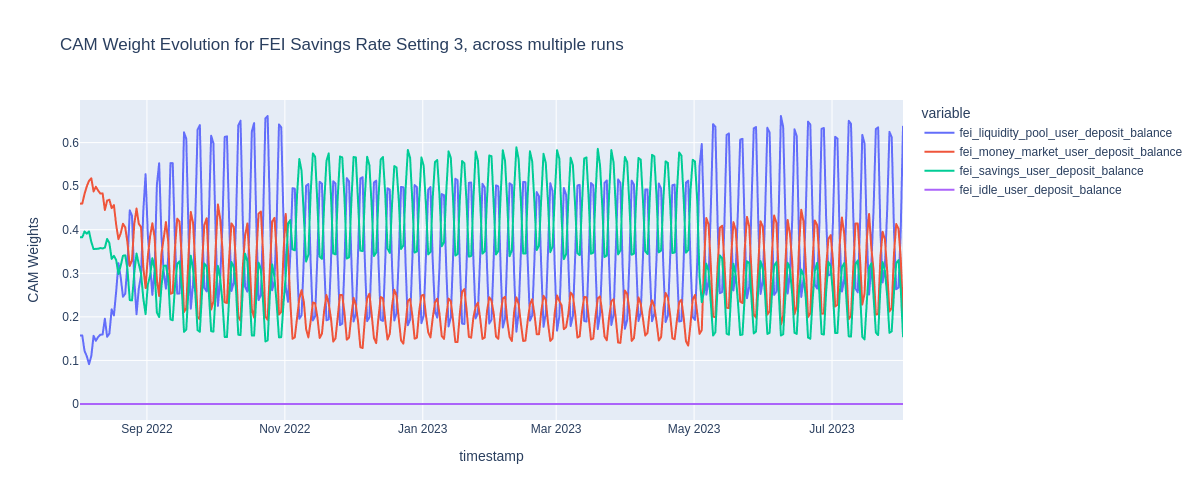

time: 899 ms (started: 2022-08-02 09:24:56 +02:00)


In [33]:
get_weight_evolution_average(df, 2).plot(
    title='CAM Weight Evolution for FEI Savings Rate Setting 3, across multiple runs',
     labels={
         "value": "CAM Weights",
     },
)

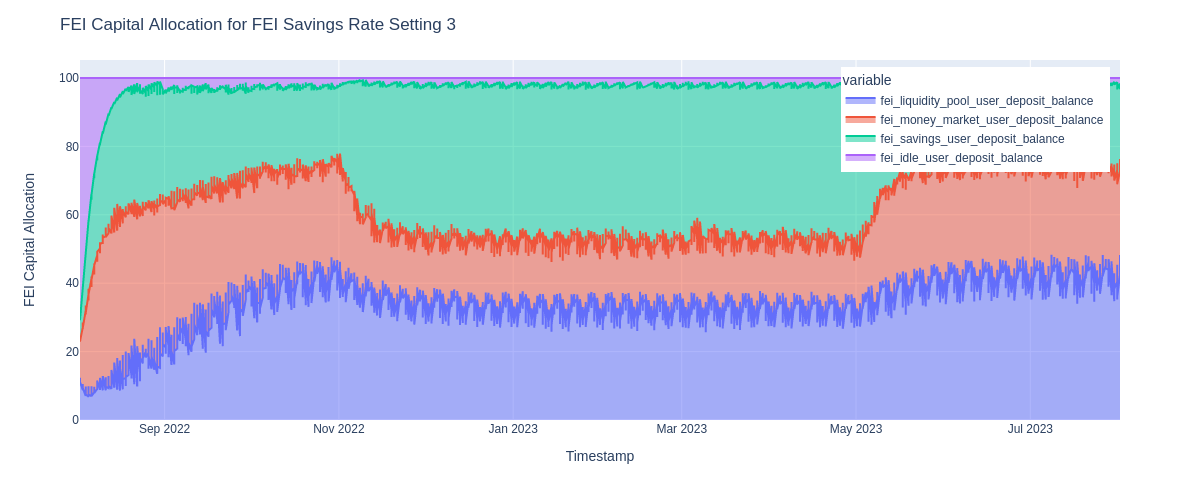

time: 363 ms (started: 2022-08-02 09:24:57 +02:00)


In [34]:
fig = px.area(df.query('subset==2'), x='timestamp', y=use_cols, groupnorm="percent")

fig.update_layout(
    title="FEI Capital Allocation for FEI Savings Rate Setting 3",
    xaxis_title="Timestamp",
    yaxis_title="FEI Capital Allocation",
    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="right",
        x=0.99
    )
)

fig.show()

### User Circulating FEI Constituents

In [35]:
# TODO - formatting for scientific notation
# df['your_col_here'].apply(lambda x: your_human_rounding_function(x))

time: 16.4 ms (started: 2022-08-02 09:24:58 +02:00)


In [36]:
#df.query('subset==0')[['total_user_circulating_fei'] + use_cols]

time: 19 ms (started: 2022-08-02 09:24:58 +02:00)


### FEI deposit sizes

In [37]:
def get_averages_by_subset(df, variables):
    L = []
    for i in df['subset'].value_counts().index:
        df_ = df.query('subset == @i')
        df_ = df_[['timestep', 'subset', 'run'] + variables].groupby('timestep').mean()
        df_.index = df.query('subset==@i and run==1')['timestamp']
        L.append(df_)
        
    return pd.concat(L, axis=0)

time: 19.5 ms (started: 2022-08-02 09:24:58 +02:00)


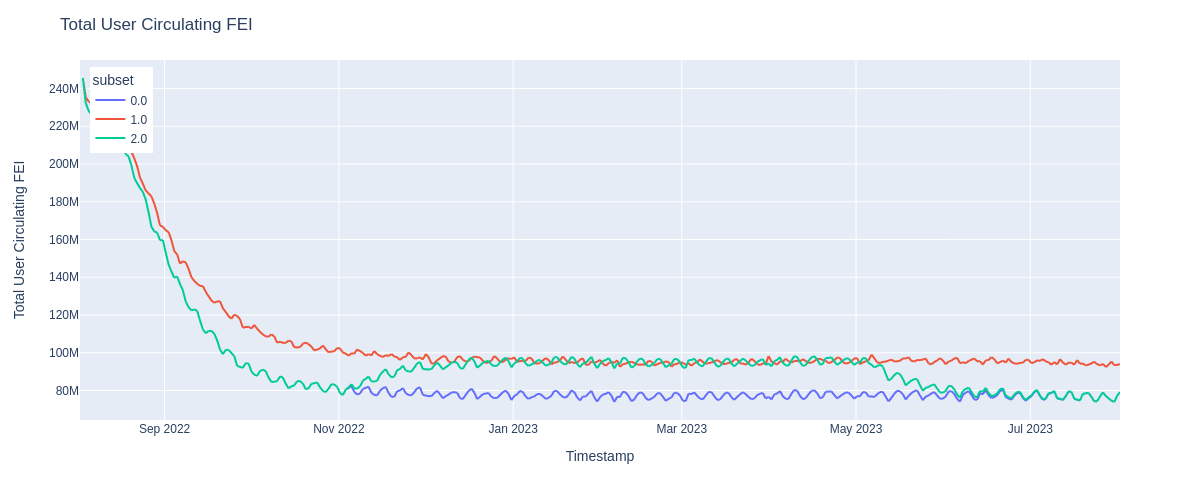

time: 777 ms (started: 2022-08-02 09:24:58 +02:00)


In [38]:
fig = get_averages_by_subset(df, ['total_user_circulating_fei']).plot(
    #x='timestep',
    y='total_user_circulating_fei',
    color='subset'
)

fig.update_layout(
    title="Total User Circulating FEI",
    xaxis_title="Timestamp",
    yaxis_title="Total User Circulating FEI",
    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01
    )
)

fig.show()

In [39]:
compute_metric_set_for_variable(df, fn_dict, 'total_user_circulating_fei')

,volatility,max,min,final value,max dd
0,0.042121,2.455803e+08,6.949045e+07,7.913834e+07,-0.499946
1,0.034693,2.455803e+08,8.745450e+07,9.398626e+07,-0.425178
2,0.038926,2.455803e+08,7.103597e+07,7.917065e+07,-0.499946


time: 339 ms (started: 2022-08-02 09:24:58 +02:00)


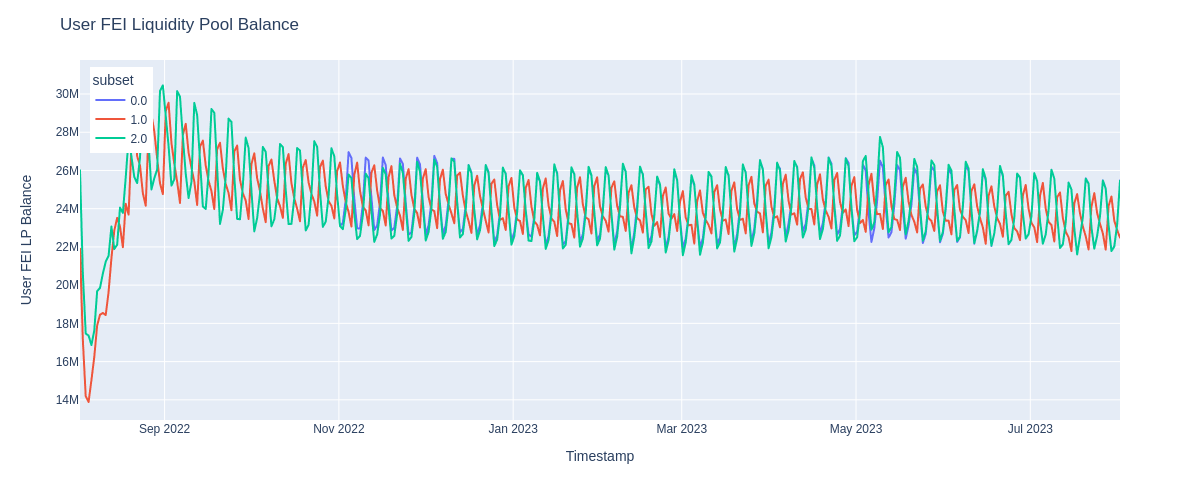

time: 842 ms (started: 2022-08-02 09:24:59 +02:00)


In [40]:
fig = get_averages_by_subset(df, ['fei_liquidity_pool_user_deposit_balance']).plot(
    #x='timestamp',
    y='fei_liquidity_pool_user_deposit_balance',
    color='subset',
)

fig.update_layout(
    title='User FEI Liquidity Pool Balance',
    xaxis_title="Timestamp",
    yaxis_title="User FEI LP Balance",

    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01
    )
)

fig.show()

In [41]:
compute_metric_set_for_variable(df, fn_dict, 'fei_liquidity_pool_user_deposit_balance', start=50, end=150)

,volatility,max,min,final value,max dd
0,0.132663,2.971878e+07,2.012005e+07,2.585139e+07,-0.307766
1,0.140867,3.001815e+07,1.999486e+07,2.288784e+07,-0.302672
2,0.131966,2.971878e+07,1.996492e+07,2.581660e+07,-0.308854


time: 302 ms (started: 2022-08-02 09:25:00 +02:00)


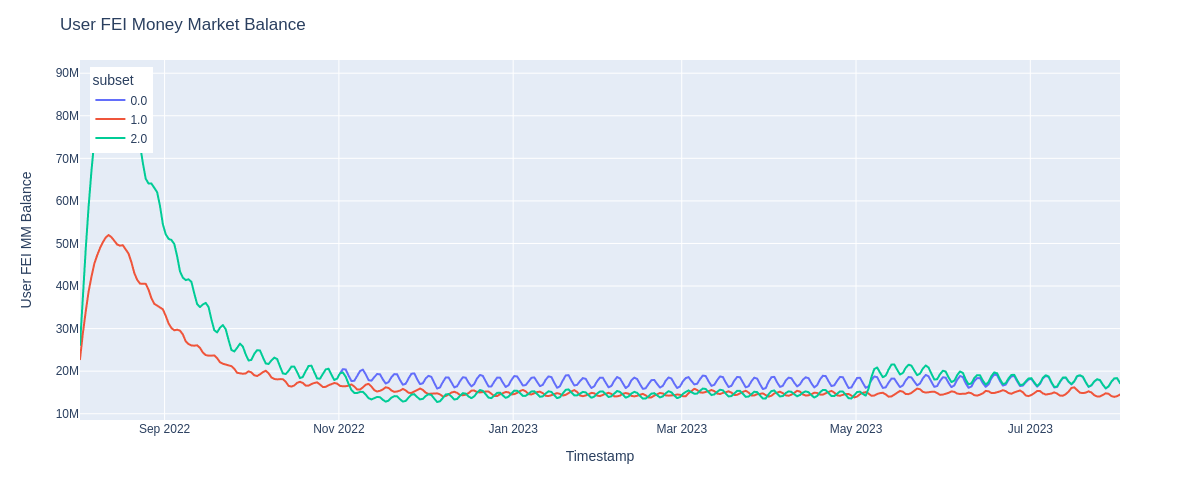

time: 805 ms (started: 2022-08-02 09:25:00 +02:00)


In [42]:
fig = get_averages_by_subset(df, ['fei_money_market_user_deposit_balance']).plot(
    #x='timestamp',
    y='fei_money_market_user_deposit_balance',
    color='subset',
)

fig.update_layout(
    title='User FEI Money Market Balance',
    xaxis_title="Timestamp",
    yaxis_title="User FEI MM Balance",

    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01
    )
)

fig.show()

In [43]:
compute_metric_set_for_variable(df, fn_dict, 'fei_money_market_user_deposit_balance')

,volatility,max,min,final value,max dd
0,0.091902,9.224044e+07,1.367360e+07,1.716485e+07,-0.662416
1,0.065670,5.276910e+07,1.179442e+07,1.451164e+07,-0.557881
2,0.080811,9.224044e+07,1.120824e+07,1.719324e+07,-0.662416


time: 312 ms (started: 2022-08-02 09:25:01 +02:00)


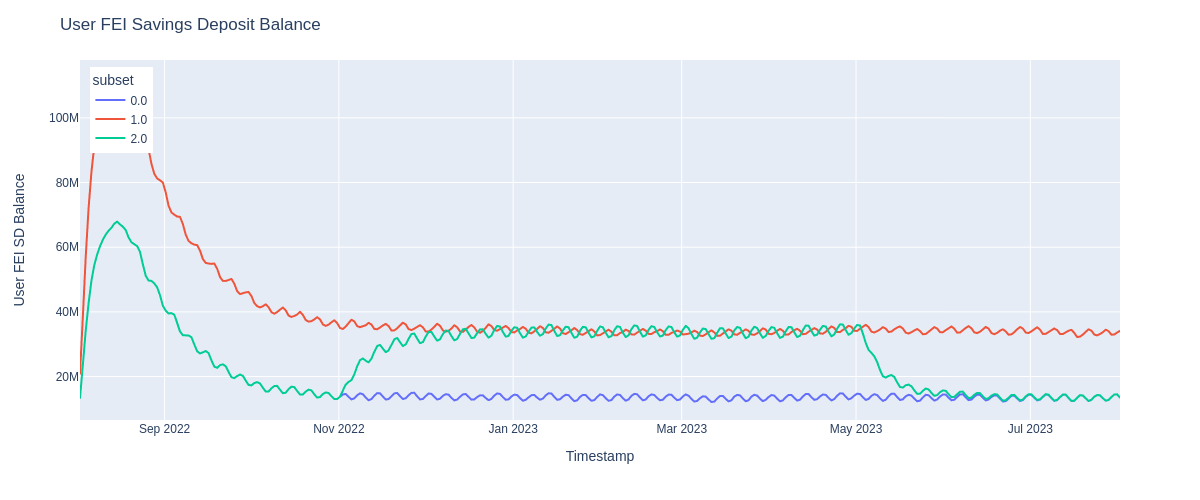

time: 772 ms (started: 2022-08-02 09:25:01 +02:00)


In [44]:
fig = get_averages_by_subset(df, ['fei_savings_user_deposit_balance']).plot(
    #x='timestep',
    y='fei_savings_user_deposit_balance',
    color='subset',
)

fig.update_layout(
    title='User FEI Savings Deposit Balance',
    xaxis_title="Timestamp",
    yaxis_title="User FEI SD Balance",

    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01
    )
)

fig.show()

In [45]:
compute_metric_set_for_variable(df, fn_dict, 'fei_savings_user_deposit_balance')

,volatility,max,min,final value,max dd
0,0.099793,7.071511e+07,1.098685e+07,1.346765e+07,-0.670753
1,0.080421,1.170164e+08,2.090196e+07,3.413279e+07,-0.540584
2,0.088866,7.071511e+07,1.127776e+07,1.348938e+07,-0.675394


time: 295 ms (started: 2022-08-02 09:25:02 +02:00)


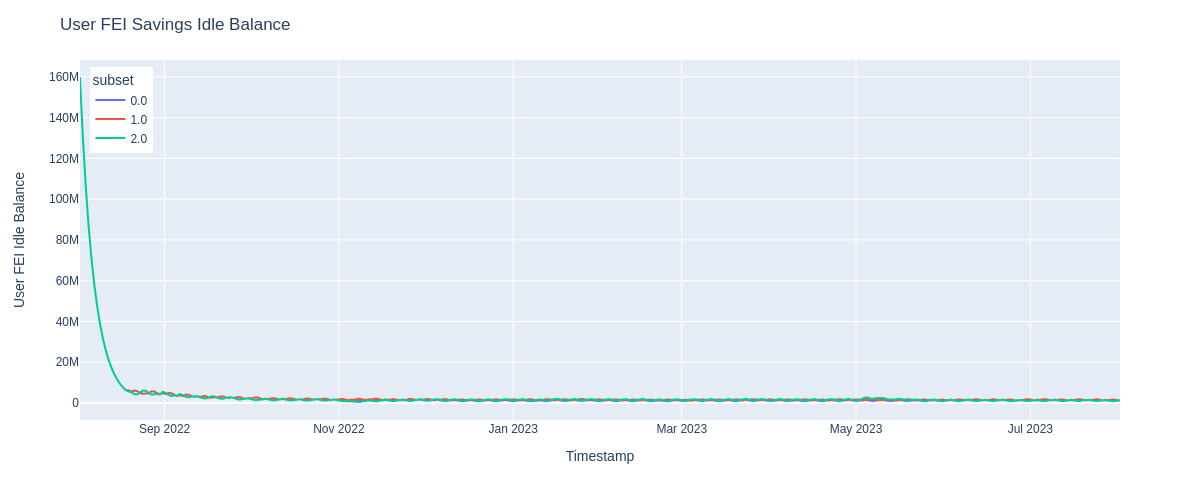

time: 877 ms (started: 2022-08-02 09:25:02 +02:00)


In [46]:
fig = get_averages_by_subset(df, ['fei_idle_user_deposit_balance']).plot(
    #x='timestep',
    y='fei_idle_user_deposit_balance',
    color='subset',
)

fig.update_layout(
    title='User FEI Savings Idle Balance',
    xaxis_title="Timestamp",
    yaxis_title="User FEI Idle Balance",

    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01
    )
)

fig.show()

In [47]:
compute_metric_set_for_variable(df, fn_dict, 'fei_savings_user_deposit_balance')

,volatility,max,min,final value,max dd
0,0.099793,7.071511e+07,1.098685e+07,1.346765e+07,-0.670753
1,0.080421,1.170164e+08,2.090196e+07,3.413279e+07,-0.540584
2,0.088866,7.071511e+07,1.127776e+07,1.348938e+07,-0.675394


time: 366 ms (started: 2022-08-02 09:25:03 +02:00)


### money market

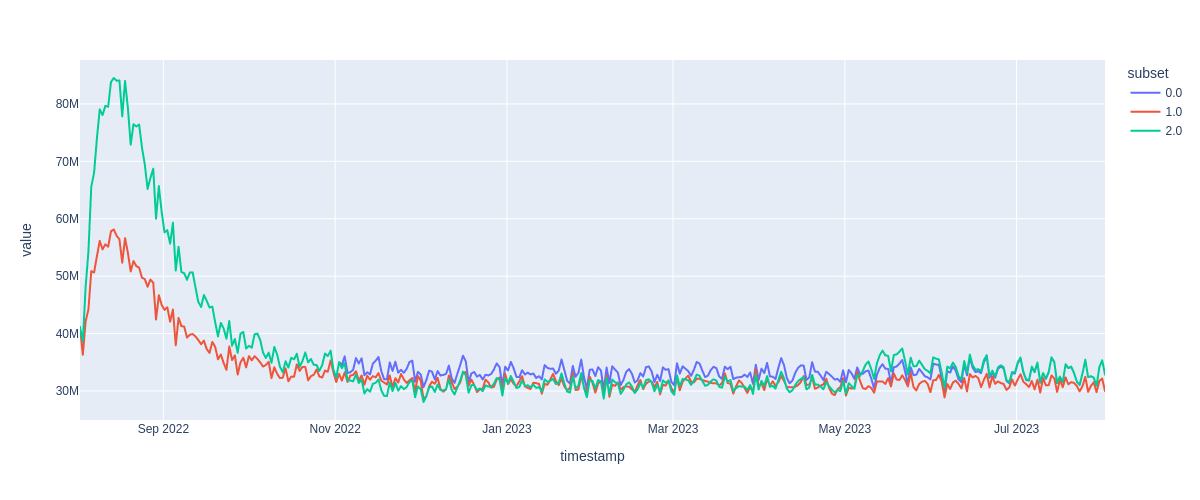

time: 840 ms (started: 2022-08-02 09:25:03 +02:00)


In [48]:
get_averages_by_subset(df, ['fei_money_market_borrowed']).plot(
    #x='timestamp',
    y=['fei_money_market_borrowed'],
    color='subset'
)

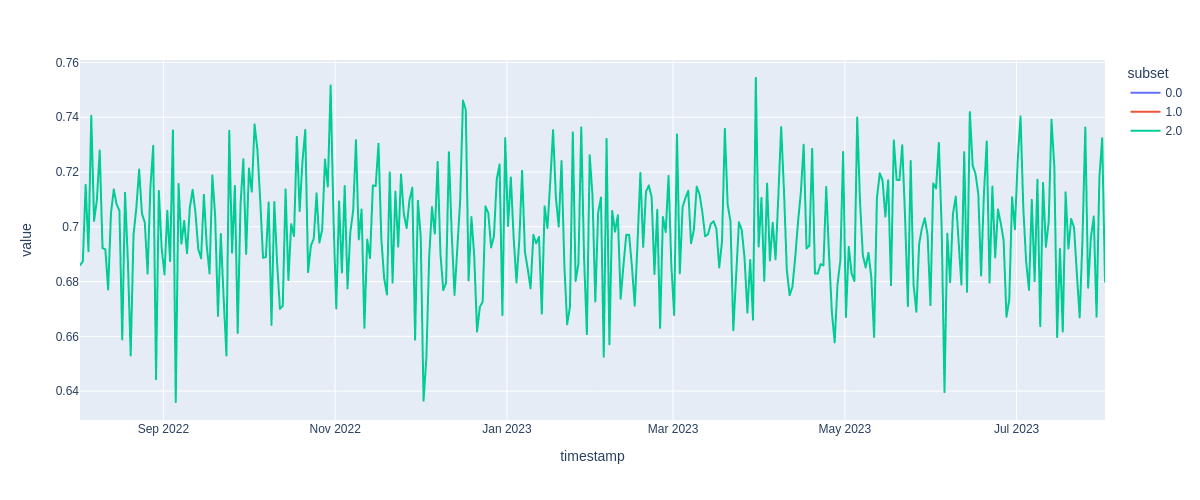

time: 812 ms (started: 2022-08-02 09:25:04 +02:00)


In [49]:
get_averages_by_subset(df, ['fei_money_market_utilization']).plot(
    #x='timestamp',
    y=['fei_money_market_utilization'],
    color='subset'
)

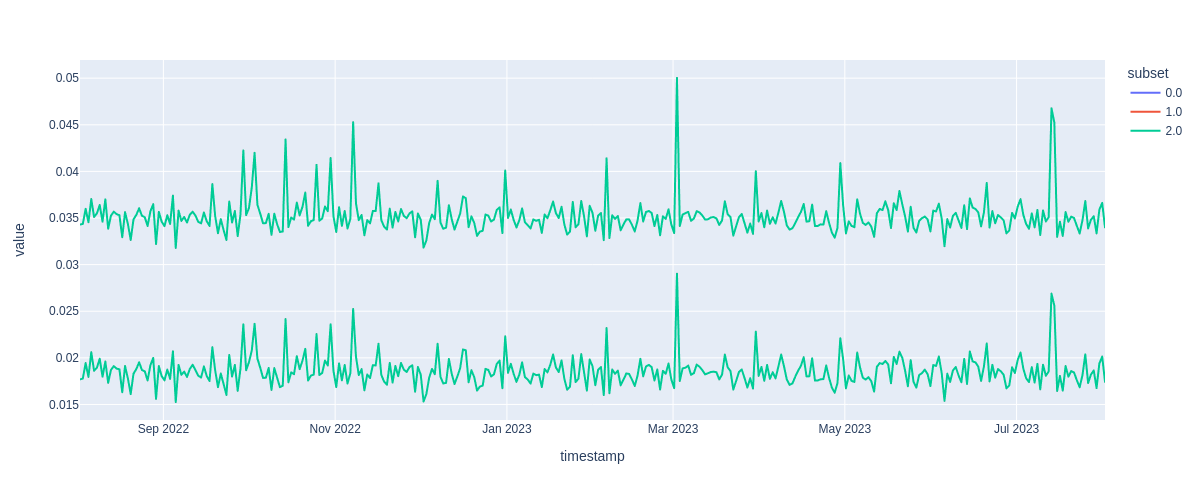

time: 966 ms (started: 2022-08-02 09:25:05 +02:00)


In [50]:
get_averages_by_subset(df, ['fei_money_market_supply_rate', 'fei_money_market_borrow_rate']).plot(
    #x='timestamp',
    y=['fei_money_market_supply_rate', 'fei_money_market_borrow_rate'],
    color='subset'
)

### liquidity pool

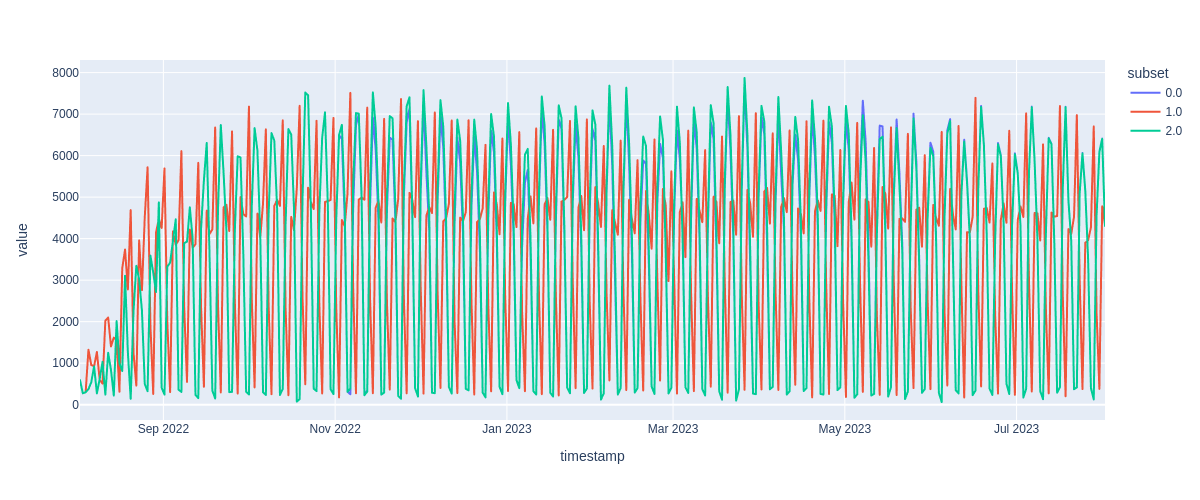

time: 858 ms (started: 2022-08-02 09:25:06 +02:00)


In [51]:
get_averages_by_subset(df, ['liquidity_pool_trading_fees']).plot(
    #x='timestamp',
    y=['liquidity_pool_trading_fees'],
    color='subset'
)

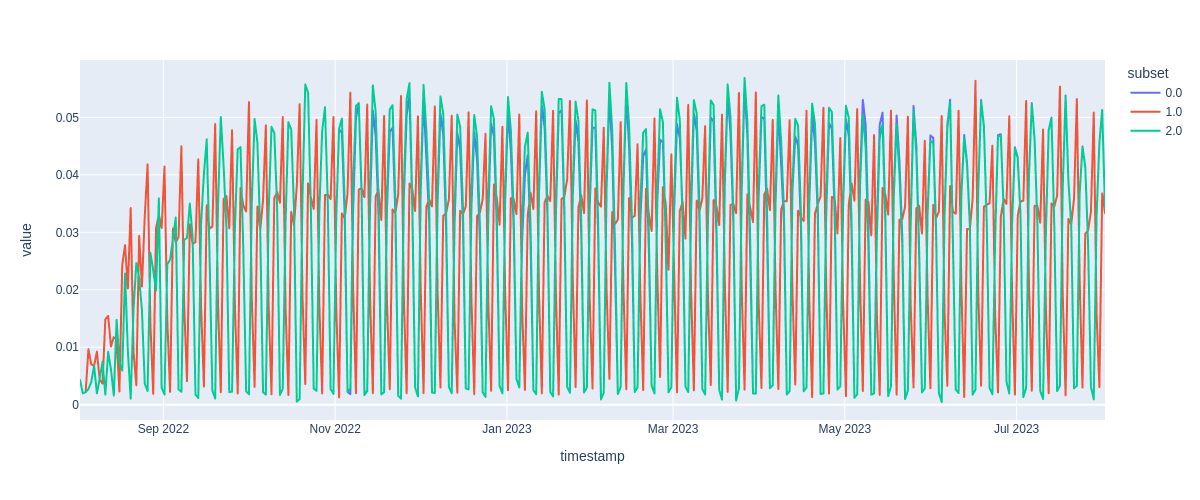

time: 916 ms (started: 2022-08-02 09:25:07 +02:00)


In [52]:
get_averages_by_subset(df, ['fei_liquidity_pool_user_deposit_yield_rate']).plot(
    #x='timestamp',
    y=['fei_liquidity_pool_user_deposit_yield_rate'],
    color='subset'
)

### fei savings deposit

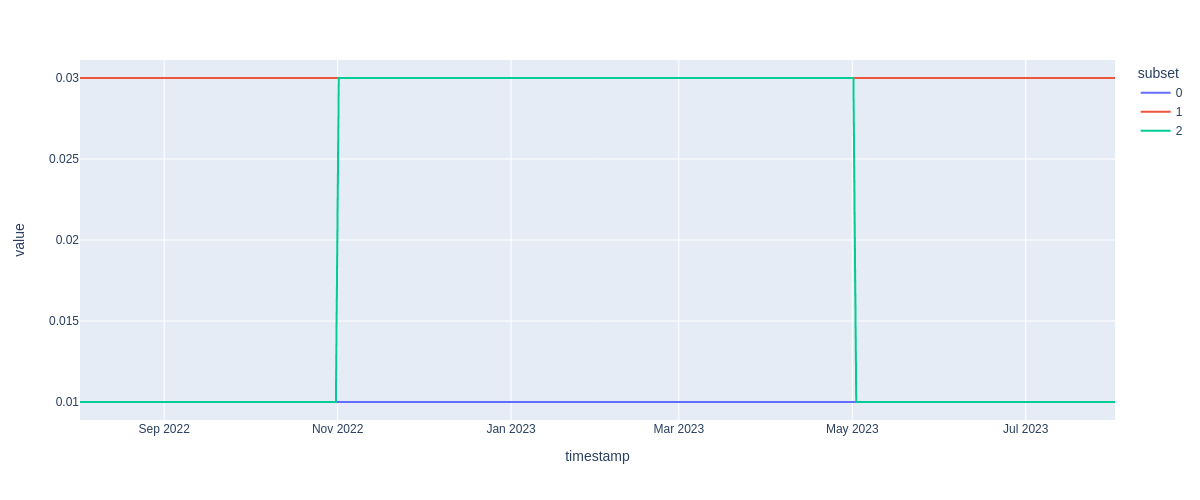

time: 878 ms (started: 2022-08-02 09:25:08 +02:00)


In [53]:
df.query('run==1').plot(x='timestamp', y=['fei_savings_rate'], color='subset')

In [54]:
#TODO: make this sensible

time: 19 ms (started: 2022-08-02 09:25:09 +02:00)


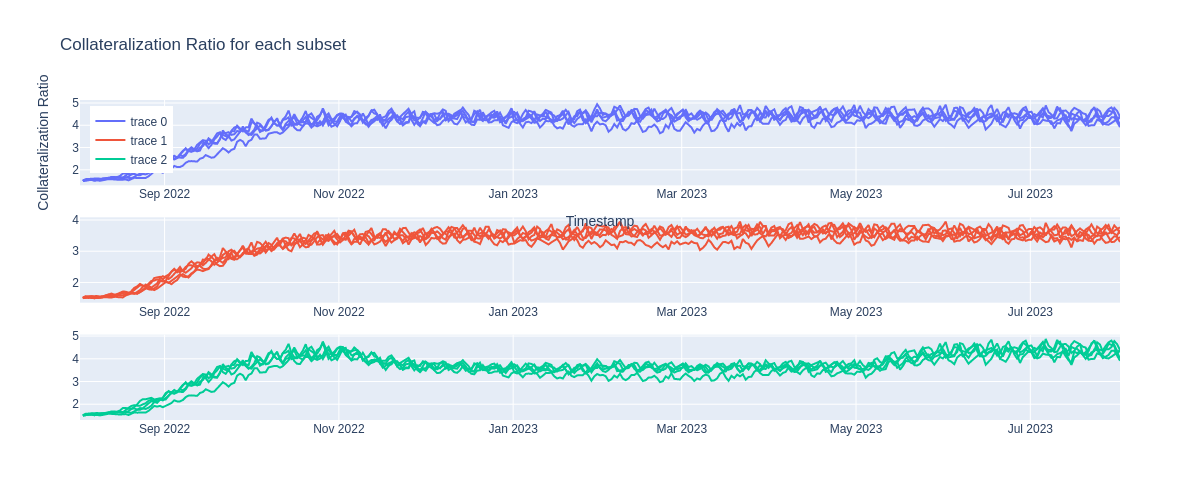

time: 287 ms (started: 2022-08-02 09:25:09 +02:00)


In [55]:
n_runs = len(df['subset'].value_counts())

fig = make_subplots(rows=n_runs, cols=1)

for i in range(n_runs):
    
    j = i+1
    
    df_ = df.query('subset==@i')

    fig.add_trace(
        go.Scatter(x=df_.index, y=df_['collateralization_ratio']),
        row=j, col=1
    )
    
fig.update_layout(
    title='Collateralization Ratio for each subset',
    xaxis_title="Timestamp",
    yaxis_title="Collateralization Ratio",

    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01
    )
)
    
fig.show()

In [56]:
# TODO: plot subplots for each of these

time: 18.8 ms (started: 2022-08-02 09:25:09 +02:00)


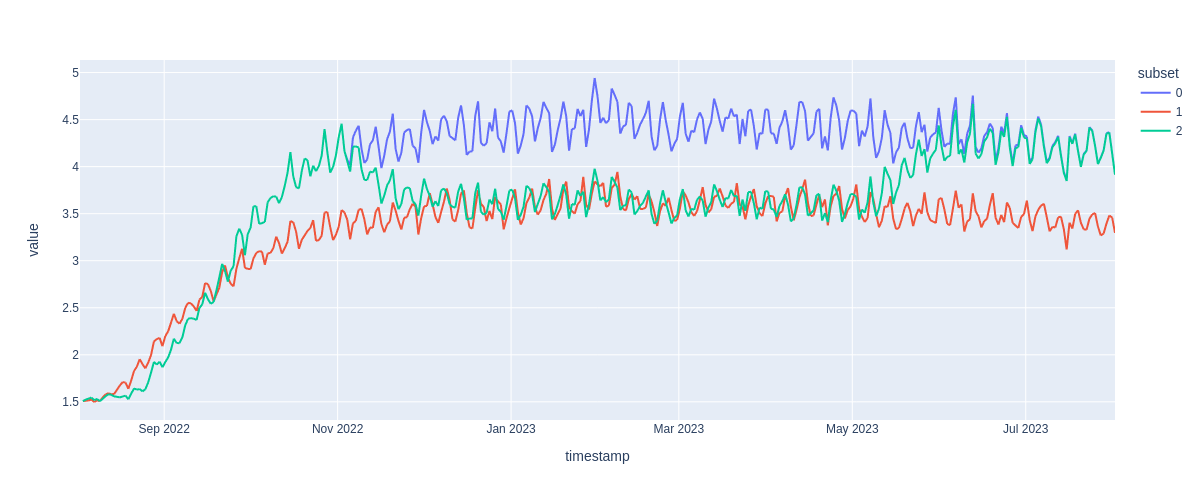

time: 704 ms (started: 2022-08-02 09:25:09 +02:00)


In [57]:
df.query('run==1').plot(x='timestamp', y=['collateralization_ratio'], color='subset')

In [58]:
compute_metric_set_for_variable(df, fn_dict, 'collateralization_ratio')

,volatility,max,min,final value,max dd
0,0.041945,4.854357,1.507236,4.213079,-0.159765
1,0.034871,3.883942,1.499128,3.552234,-0.142427
2,0.038910,4.747786,1.507236,4.211867,-0.225004


time: 343 ms (started: 2022-08-02 09:25:10 +02:00)


In [59]:
#df.plot(x='timestamp', y=['stable_backing_ratio'], color='subset')

time: 19.4 ms (started: 2022-08-02 09:25:10 +02:00)


In [60]:
#(df.query('subset==0')['fei_money_market_supply_rate'] - df.query('subset==0')['fei_savings_rate']).plot()

time: 19.2 ms (started: 2022-08-02 09:25:10 +02:00)


# KPIs

In [61]:
# whats the probability that the state variable has a volatility greater than x for this policy setting?

time: 17.3 ms (started: 2022-08-02 09:25:10 +02:00)


## Conclusion

From this analyisis we can make the following qualitative conclusion - when aggregate demand for deposits is based on yield rates as the only driver of utility, deposit population will converge to the mechanism offering the highest yield. We notice specifically that in trajectory 3, given the non-instantaneous rebalance velocity, that utilization of the FSD never reaches that attained in trajectory 2, but also does not fall back below that of trajectory 1.

We furthermore notice the existance of downstream effects on money market utilization and liquidity pool yield, more greatly sustained when both these deposits have higher affluence.

We finally notice some minor downstream effects on the collateralization ratio. Here, this process is affected by changes in PCV value and PCV yield accrued, as well as changes in user circulating FEI, the former affected by money market usage and the latter by liquidity pool usage.

# Other 

In [62]:
generate_emp_distribution_kpi(compute_vol, df, 'total_user_circulating_fei')

,0,1,2
1,0.041023,0.035804,0.037975
2,0.043582,0.034853,0.040342
3,0.042665,0.033347,0.039141
4,0.042166,0.034655,0.038895
5,0.041172,0.034805,0.038277


time: 75.1 ms (started: 2022-08-02 09:25:10 +02:00)


In [63]:
# whats the probability that the state variable falls below x for this policy setting?

time: 15.4 ms (started: 2022-08-02 09:25:10 +02:00)


In [64]:
generate_emp_distribution_kpi(compute_min, df, 'total_user_circulating_fei')

,0,1,2
1,6.842575e+07,8.761547e+07,6.972605e+07
2,7.216210e+07,9.038596e+07,7.220040e+07
3,6.198428e+07,7.782002e+07,6.538996e+07
4,7.187200e+07,9.008280e+07,7.375206e+07
5,7.300810e+07,9.136825e+07,7.411135e+07


time: 71.2 ms (started: 2022-08-02 09:25:10 +02:00)


In [65]:
# whats the probability that the state variable ends up at at least x for this policy setting?

time: 16 ms (started: 2022-08-02 09:25:10 +02:00)


In [66]:
generate_emp_distribution_kpi(compute_final_val, df, 'total_user_circulating_fei')

,0,1,2
1,7.758572e+07,9.228274e+07,7.764722e+07
2,8.204220e+07,9.446454e+07,8.202656e+07
3,7.205497e+07,8.414760e+07,7.215325e+07
4,8.270495e+07,9.895502e+07,8.271807e+07
5,8.130384e+07,1.000814e+08,8.130814e+07


time: 77.1 ms (started: 2022-08-02 09:25:10 +02:00)


In [67]:
generate_emp_distribution_kpi(compute_mdd, df, 'total_user_circulating_fei')

,0,1,2
1,-0.475223,-0.427893,-0.475223
2,-0.528444,-0.407430,-0.528444
3,-0.523404,-0.436422,-0.523404
4,-0.507502,-0.416784,-0.507502
5,-0.465158,-0.437363,-0.465158


time: 78 ms (started: 2022-08-02 09:25:10 +02:00)


In [68]:
s = df.query('run== 1 and subset== 0')['total_user_circulating_fei']
s2 = df.query('run== 1 and subset== 2')['total_user_circulating_fei']
compute_mdd(s[150:])
compute_mdd(s2[150:])

-0.2722434839952511

time: 27.7 ms (started: 2022-08-02 09:25:10 +02:00)


In [69]:
# what is the probability that CR >= 1? VA price analysis

time: 17.6 ms (started: 2022-08-02 09:25:10 +02:00)


In [70]:
df.query('subset == 0 and run==1')['collateralization_ratio'] - df.query('subset == 1 and run==1')['collateralization_ratio']

timestamp
2022-08-02 09:24:20.688821             NaN
2022-08-03 09:24:20.688821   -4.440892e-16
2022-08-04 09:24:20.688821    1.176787e-02
2022-08-05 09:24:20.688821    1.902958e-02
2022-08-06 09:24:20.688821    2.019090e-02
                                  ...     
2023-07-28 09:24:20.688821    8.851995e-01
2023-07-29 09:24:20.688821    9.604402e-01
2023-07-30 09:24:20.688821    8.848402e-01
2023-07-31 09:24:20.688821    6.837066e-01
2023-08-01 09:24:20.688821    6.207565e-01
Name: collateralization_ratio, Length: 365, dtype: float64

time: 27.6 ms (started: 2022-08-02 09:25:10 +02:00)


In [71]:
df.query('subset == 0 and run==2')['collateralization_ratio'] - df.query('subset == 1 and run==2')['collateralization_ratio']

timestamp
2022-08-02 09:24:20.688821         NaN
2022-08-03 09:24:20.688821    0.000000
2022-08-04 09:24:20.688821    0.017283
2022-08-05 09:24:20.688821    0.029584
2022-08-06 09:24:20.688821    0.038696
                                ...   
2023-07-28 09:24:20.688821    1.020237
2023-07-29 09:24:20.688821    1.216450
2023-07-30 09:24:20.688821    0.951146
2023-07-31 09:24:20.688821    0.631325
2023-08-01 09:24:20.688821    0.567861
Name: collateralization_ratio, Length: 365, dtype: float64

time: 30.4 ms (started: 2022-08-02 09:25:11 +02:00)


In [72]:
# nonparametric hypothesis test:
# statistic - difference in - collateral ratio, stable backing ratio across pairs of policies for runs
# test: h0 Delta_v2 - Delta_v1 = 0, h1: Delta_v2 - Delta_v1 =/= 0
# https://www.investopedia.com/terms/t/t-test.asp
# https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

time: 18.1 ms (started: 2022-08-02 09:25:11 +02:00)
